# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [2]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from pandas.core import datetools
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [3]:
train_test_split?

In [4]:
# your code here
bikes_main=pd.read_csv('data/bikes_student.csv')
bikes_main=bikes_main.drop('Unnamed: 0',axis=1)
bikes_train,bikes_val=train_test_split(bikes_main,test_size=0.2,random_state=90,stratify=bikes_main['month'])
bikes_train.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
540,2012-10-23,23,1,0,1,0.54,0.5152,0.73,0.1045,9,...,0,1,0,0,0,0,0,0,0,10
367,2011-06-29,11,0,0,1,0.76,0.6667,0.35,0.2239,53,...,0,0,1,0,0,0,0,0,0,6
869,2012-08-24,2,1,0,1,0.66,0.6212,0.69,0.0000,1,...,0,0,0,0,1,0,0,0,0,8
216,2012-10-31,5,1,0,1,0.30,0.3030,0.81,0.1343,0,...,0,0,1,0,0,0,1,0,0,10
238,2012-08-24,21,1,0,1,0.70,0.6515,0.61,0.1642,58,...,0,0,0,0,1,0,1,0,0,8


**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [5]:
# your code here
def drop_features_split_data(df,target_col,drop_col):
    y_train=df[[target_col]]
    x_train=df.drop(drop_col,axis=1)
    return x_train,y_train

practice_X_train,practice_y_train=drop_features_split_data(bikes_train,'counts',['counts','registered','casual','workingday','month','dteday'])
practice_X_train.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
540,23,1,0,0.54,0.5152,0.73,0.1045,0,0,0,...,1,0,1,0,0,0,0,0,0,0
367,11,0,0,0.76,0.6667,0.35,0.2239,0,0,0,...,0,0,0,1,0,0,0,0,0,0
869,2,1,0,0.66,0.6212,0.69,0.0000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
216,5,1,0,0.30,0.3030,0.81,0.1343,0,0,0,...,1,0,0,1,0,0,0,1,0,0
238,21,1,0,0.70,0.6515,0.61,0.1642,0,0,0,...,0,0,0,0,0,1,0,1,0,0


**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [6]:
# your code here

binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']

def standardize(train_df,test_df,cols_to_scale):
    
    train = train_df.copy()
    test = test_df.copy()
    
    scaler=StandardScaler().fit(train[cols_to_scale])
    train[cols_to_scale]=scaler.transform(train[cols_to_scale])
    test[cols_to_scale]=scaler.transform(test[cols_to_scale])
    
    return train, test

to_scale=practice_X_train.columns.difference(binary_columns)

practice_X_train_scaled,_=standardize(practice_X_train,practice_X_train,to_scale)
practice_X_train_scaled.describe()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,-1.994516e-16,2.686740e-17,0.027000,3.019807e-17,-1.256772e-16,5.995204e-17,1.301181e-16,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,1.000500e+00,1.000500e+00,0.162164,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,-1.646163e+00,-1.018165e+00,0.000000,-2.347976e+00,-2.402605e+00,-3.397602e+00,-1.554205e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,-9.189949e-01,-1.018165e+00,0.000000,-7.922693e-01,-8.121270e-01,-7.421467e-01,-7.231056e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,-4.639332e-02,9.821591e-01,0.000000,3.744066e-02,7.147176e-02,5.448995e-02,-1.130295e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,8.262083e-01,9.821591e-01,0.000000,8.671507e-01,8.670022e-01,8.511266e-01,4.634972e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,1.698810e+00,9.821591e-01,1.000000,2.319143e+00,2.546131e+00,1.913309e+00,5.211499e+00,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 



Encapsulate this process as a function with apropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with qudratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

In [7]:
poly=PolynomialFeatures(2,include_bias=False)
a=np.arange(1,5).reshape(-1,1)
k=poly.fit_transform(a)
b=poly.get_feature_names(['temp'])
b

['temp', 'temp^2']

In [8]:
# your code here
poly_feautures=['temp', 'atemp', 'hum','windspeed', 'hour']

def poly_features(train_data,poly_columns,degree):
    
    poly_dataset = train_data.copy()
    
    poly=PolynomialFeatures(degree,include_bias=False)
    for cur_col in poly_columns:
        poly_values=poly.fit_transform(poly_dataset[[cur_col]])
        poly_names=poly.get_feature_names([cur_col])
        
        to_add=pd.DataFrame(poly_values[:,1:],index=poly_dataset.index,columns=poly_names[1:])
        poly_dataset=pd.concat([poly_dataset,to_add],axis=1)
    
    return poly_dataset

practice_X_train_poly= poly_features(practice_X_train_scaled,poly_feautures,3)

print(practice_X_train_poly.columns,'\n')
practice_X_train_poly.head()

       


Index(['hour', 'year', 'holiday', 'temp', 'atemp', 'hum', 'windspeed', 'Feb',
       'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec',
       'spring', 'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'temp^2', 'temp^3', 'atemp^2', 'atemp^3',
       'hum^2', 'hum^3', 'windspeed^2', 'windspeed^3', 'hour^2', 'hour^3'],
      dtype='object') 



,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,temp^2,temp^3,atemp^2,atemp^3,hum^2,hum^3,windspeed^2,windspeed^3,hour^2,hour^3
540,1.698810,0.982159,0,0.244868,0.248775,0.479363,-0.723106,0,0,0,...,0.059960,0.014682,0.061889,0.015396,0.229789,0.110152,0.522882,-0.378099,2.885955,4.902689
367,-0.046393,-1.018165,0,1.385719,1.132373,-1.538783,0.226495,0,0,0,...,1.920218,2.660884,1.282270,1.452008,2.367854,-3.643615,0.051300,0.011619,0.002152,-0.000100
869,-1.355296,0.982159,0,0.867151,0.867002,0.266926,-1.554205,0,0,0,...,0.751950,0.652054,0.751693,0.651719,0.071250,0.019018,2.415552,-3.754263,1.836827,-2.489443
216,-0.918995,0.982159,0,-0.999697,-0.988847,0.904236,-0.486103,0,0,0,...,0.999394,-0.999091,0.977818,-0.966912,0.817642,0.739341,0.236296,-0.114864,0.844552,-0.776139
238,1.407943,0.982159,0,1.074578,1.043722,-0.157946,-0.248305,0,0,0,...,1.154718,1.240835,1.089356,1.136984,0.024947,-0.003940,0.061656,-0.015309,1.982303,2.790969


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

In [9]:
# your code here
interaction_left=['temp','atemp', 'hum','windspeed']
interaction_right=['Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
def build_interactions(df,interaction_left,interaction_right):
    for col_left in interaction_left:
        for col_right in interaction_right:
            df[col_left+'*'+col_right]=df[col_left]*df[col_right]
    return df

                
practice_X_train_interact=build_interactions(practice_X_train_poly,interaction_left,interaction_right)  
print(practice_X_train_interact.columns.values)
practice_X_train_interact.head()

      
        

['hour' 'year' 'holiday' 'temp' 'atemp' 'hum' 'windspeed' 'Feb' 'Mar'
 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sept' 'Oct' 'Nov' 'Dec' 'spring' 'summer'
 'fall' 'Mon' 'Tue' 'Wed' 'Thu' 'Fri' 'Sat' 'Cloudy' 'Snow' 'Storm'
 'temp^2' 'temp^3' 'atemp^2' 'atemp^3' 'hum^2' 'hum^3' 'windspeed^2'
 'windspeed^3' 'hour^2' 'hour^3' 'temp*Feb' 'temp*Mar' 'temp*Apr'
 'temp*May' 'temp*Jun' 'temp*Jul' 'temp*Aug' 'temp*Sept' 'temp*Oct'
 'temp*Nov' 'temp*Dec' 'temp*Mon' 'temp*Tue' 'temp*Wed' 'temp*Thu'
 'temp*Fri' 'temp*Sat' 'atemp*Feb' 'atemp*Mar' 'atemp*Apr' 'atemp*May'
 'atemp*Jun' 'atemp*Jul' 'atemp*Aug' 'atemp*Sept' 'atemp*Oct' 'atemp*Nov'
 'atemp*Dec' 'atemp*Mon' 'atemp*Tue' 'atemp*Wed' 'atemp*Thu' 'atemp*Fri'
 'atemp*Sat' 'hum*Feb' 'hum*Mar' 'hum*Apr' 'hum*May' 'hum*Jun' 'hum*Jul'
 'hum*Aug' 'hum*Sept' 'hum*Oct' 'hum*Nov' 'hum*Dec' 'hum*Mon' 'hum*Tue'
 'hum*Wed' 'hum*Thu' 'hum*Fri' 'hum*Sat' 'windspeed*Feb' 'windspeed*Mar'
 'windspeed*Apr' 'windspeed*May' 'windspeed*Jun' 'windspeed*Jul'
 'windspeed*Aug' 

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
540,1.698810,0.982159,0,0.244868,0.248775,0.479363,-0.723106,0,0,0,...,-0.0,-0.723106,-0.0,-0.0,-0.0,-0.723106,-0.000000,-0.0,-0.000000,-0.0
367,-0.046393,-1.018165,0,1.385719,1.132373,-1.538783,0.226495,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.226495,0.0,0.000000,0.0
869,-1.355296,0.982159,0,0.867151,0.867002,0.266926,-1.554205,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-1.554205,-0.0
216,-0.918995,0.982159,0,-0.999697,-0.988847,0.904236,-0.486103,0,0,0,...,-0.0,-0.486103,-0.0,-0.0,-0.0,-0.000000,-0.486103,-0.0,-0.000000,-0.0
238,1.407943,0.982159,0,1.074578,1.043722,-0.157946,-0.248305,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.248305,-0.0


**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [10]:

def get_design_mats(train_df, val_df, degree,
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    
    #drop columns and split data 
    
    X_train,y_train=drop_features_split_data(train_df,target_col,bad_columns)
    X_val,y_val=drop_features_split_data(val_df,target_col,bad_columns)
    
    
    #standardize the features of train and validation data
    
    binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']
    
    to_scale=X_train.columns.difference(binary_columns)
    
    X_train_scaled,X_val_scaled=standardize(X_train,X_val,to_scale)
    
    #add polynomial terms to train and validation data
    
    X_train_poly= poly_features(X_train_scaled,columns_forpoly,degree)
    X_val_poly = poly_features(X_val_scaled,columns_forpoly,degree)
    
    #add interaction terms to train and validation data
    interaction_left=['temp','atemp', 'hum','windspeed']
    interaction_right=['Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    
    X_train_interact=build_interactions(X_train_poly,interaction_left,interaction_right)
    X_val_interact= build_interactions(X_val_poly,interaction_left,interaction_right)
    
    x_train= X_train_interact
    x_val= X_val_interact
    
    # add code here 
    return x_train,y_train, x_val,y_val

In [11]:
# your code here
x_train,y_train, x_val,y_val=get_design_mats(bikes_train, bikes_val, 4,
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday'])


<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

In [12]:
degrees=range(1,9)
degrees

range(1, 9)

In [13]:
# your code here
degrees=np.arange(1,9)
train_scores=[]
test_scores=[]
for i in degrees:
    x_train,y_train, x_val,y_val=get_design_mats(bikes_train, bikes_val, i)
    
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    train_score=r2_score(y_train,lr.predict(x_train))
    test_score=r2_score(y_val,lr.predict(x_val))
    train_scores.append(train_score)
    test_scores.append(test_score)

scores={'train_score':train_scores,'test_scores':test_scores}    
score_df=pd.DataFrame(scores,index=degrees)
score_df



,train_score,test_scores
1,0.484997,0.333359
2,0.577436,0.450571
3,0.626488,0.461470
4,0.632332,0.445117
5,0.647222,0.477027
6,0.668668,0.478536
7,0.697748,0.537901
8,0.706927,0.556701


**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

*your answer here*


**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [14]:
fitted_Ridge_model.score?

Object `fitted_Ridge_model.score` not found.


In [15]:
# your code here
degrees=np.arange(1,9)
lambdas =(0.01,0.05,0.5,1,5,10,50,100)

train_values=np.ones((len(degrees),len(lambdas)))
val_values=np.ones((len(degrees),len(lambdas)))


for i,cur_degree in enumerate(degrees):
    x_train,y_train, x_val,y_val=get_design_mats(bikes_train, bikes_val, cur_degree)
    for j,lam in enumerate(lambdas):
        fitted_Ridge_model=Ridge(alpha=lam).fit(x_train,y_train)
        train_score=fitted_Ridge_model.score(x_train,y_train)
        test_score=r2_score(y_val,fitted_Ridge_model.predict(x_val))
        train_values[i,j]=train_score
        val_values[i,j]=test_score
        

train_scores_df=pd.DataFrame(train_values,index=degrees,columns=lambdas)        
print("Train scores")
display(train_scores_df)

val_scores_df=pd.DataFrame(val_values,index=degrees,columns=lambdas)
print("Validation scores")
display(val_scores_df)


Train scores


,0.01,0.05,0.5,1.0,5.0,10.0,50.0,100.0
1,0.484979,0.484820,0.482444,0.480700,0.475369,0.471987,0.455275,0.441231
2,0.577396,0.577126,0.573921,0.571844,0.565708,0.561962,0.545581,0.532917
3,0.626462,0.626235,0.622999,0.621028,0.615365,0.611173,0.584376,0.559400
4,0.632325,0.632201,0.629976,0.628493,0.622997,0.617962,0.587829,0.562649
5,0.647211,0.647070,0.644872,0.643461,0.638529,0.634383,0.612143,0.593816
6,0.668658,0.668515,0.666561,0.665167,0.658677,0.653198,0.627980,0.607275
7,0.697729,0.697494,0.693984,0.690452,0.672604,0.661439,0.626304,0.604670
8,0.706900,0.706537,0.700066,0.694008,0.671939,0.661135,0.630047,0.611475


Validation scores


,0.01,0.05,0.5,1.0,5.0,10.0,50.0,100.0
1,0.334079,0.336303,0.344601,0.347245,0.350852,0.350720,0.345421,0.340400
2,0.451156,0.452777,0.458863,0.460860,0.462742,0.461501,0.453643,0.448234
3,0.462133,0.464616,0.474055,0.477064,0.482930,0.484346,0.477066,0.464374
4,0.445810,0.448139,0.457269,0.460419,0.467707,0.470200,0.466792,0.458405
5,0.477541,0.479419,0.486543,0.488813,0.493436,0.494610,0.491686,0.487166
6,0.479001,0.480442,0.487837,0.491471,0.499539,0.501450,0.500695,0.496005
7,0.538235,0.538780,0.537512,0.534090,0.518093,0.511204,0.498667,0.492277
8,0.556880,0.556861,0.548498,0.539885,0.514831,0.508011,0.500281,0.497137


**2.4** Find the best-scoring degree and regularization combination.

In [16]:
# your code here
print(np.max(val_values))
best_degree_ind=np.argmax(np.max(val_values,axis=1))
best_alpha_ind=np.argmax(np.max(val_values,axis=0))
best_degree=degrees[best_degree_ind]
best_alpha=lambdas[best_alpha_ind]
print("The best model has degree {} and Lambda={}.".format(best_degree, 
                                                           best_alpha))

print("The best model has R2={}".format(val_values[best_degree_ind, best_alpha_ind]))


0.5568797750214243
The best model has degree 8 and Lambda=0.01.
The best model has R2=0.5568797750214243


**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [23]:
# your code here
bikes_test=pd.read_csv('data/bikes_test.csv')
bikes_test=bikes_test.drop('Unnamed: 0',axis=1)
x_train,y_train, x_test,y_test=get_design_mats(bikes_main, bikes_test, best_degree)
fitted_model=Ridge(alpha=best_alpha).fit(x_train,y_train)
test_r2_score=r2_score(y_test,fitted_model.predict(x_test))
test_r2_score

0.5867680058435814

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

In [18]:
# your code here


*your answer here*


<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [58]:
#your code here
x_train31, y_train31, x_val31, y_val31 = get_design_mats(bikes_main, bikes_val, 1)

fitted_OLS = LinearRegression().fit(x_train31,y_train31)

alphas = [0.1,0.5,1,5,10,50,100] 

fitted_ridge = RidgeCV(alphas=alphas).fit(x_train31, y_train31)
fitted_lasso = LassoCV(alphas=alphas, max_iter=100000).fit(x_train31, np.ravel(y_train31))


**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

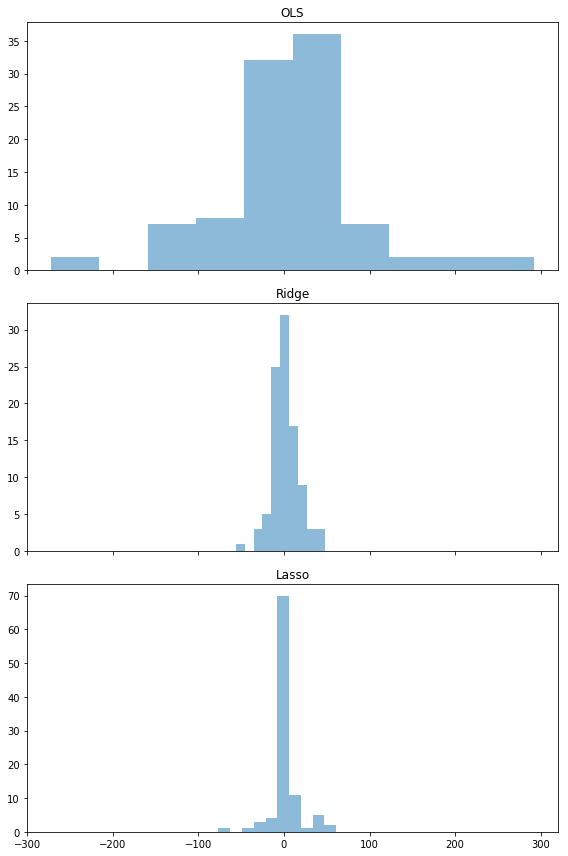

In [61]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
alpha=0.5

axs[0].hist(fitted_OLS.coef_[0], alpha=alpha)
axs[0].set_title("OLS")

axs[1].hist(fitted_ridge.coef_[0], alpha=alpha)
axs[1].set_title("Ridge")

axs[2].hist(fitted_lasso.coef_, alpha=alpha)
axs[2].set_title("Lasso")
plt.tight_layout()

*your answer here*


**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

In [74]:
x_train31.columns.shape[0]

98

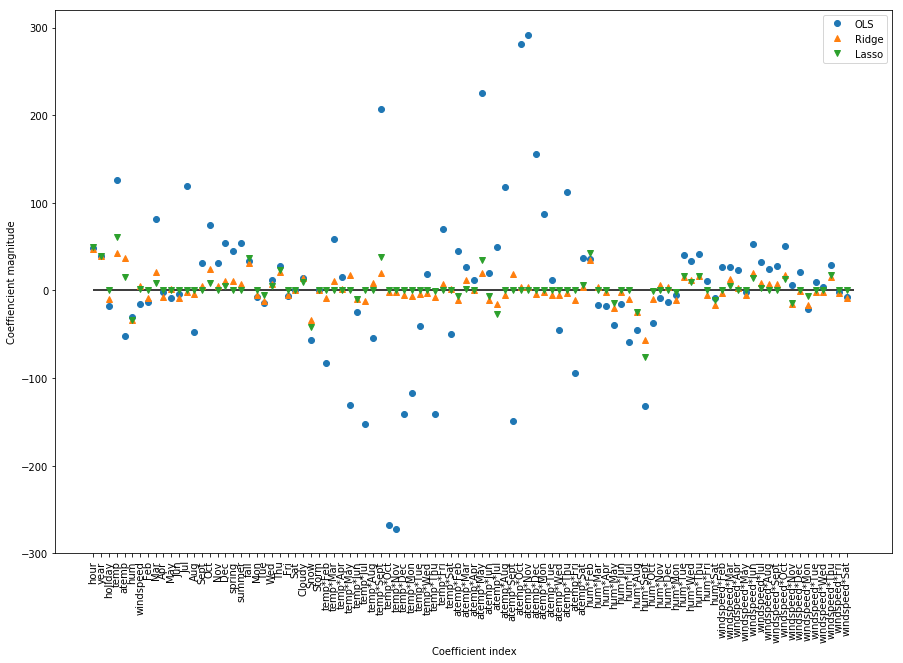

In [81]:
# your code here
fig = plt.figure(figsize=(15, 10))
plt.plot(fitted_OLS.coef_[0],'o',label='OLS')
plt.plot(fitted_ridge.coef_[0],'^',label='Ridge')
plt.plot(fitted_lasso.coef_,'v',label='Lasso')
plt.xticks(range(x_train31.columns.shape[0]),x_train31.columns,rotation=90)
plt.hlines(0,0,x_train31.columns.shape[0])
plt.xlabel('Coefficient index')
plt.ylabel('Coeffiencient magnitude')
plt.legend()
plt.show()

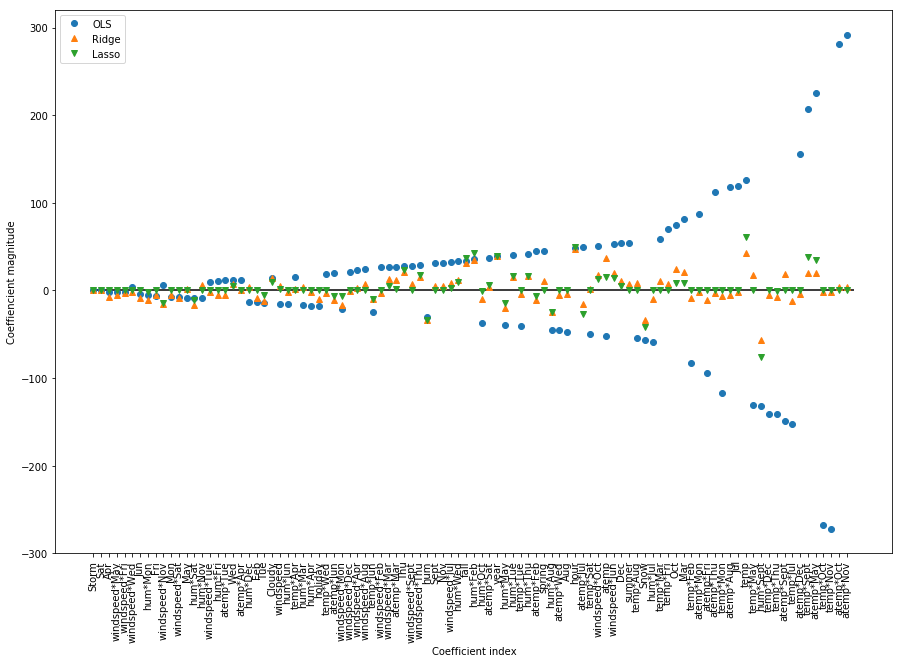

In [112]:
si=np.argsort(np.abs(fitted_OLS.coef_[0]))
fig = plt.figure(figsize=(15, 10))
plt.plot(fitted_OLS.coef_[0][si],'o',label='OLS')
plt.plot(fitted_ridge.coef_[0][si],'^',label='Ridge')
plt.plot(fitted_lasso.coef_[si],'v',label='Lasso')
plt.xticks(range(x_train31.columns.shape[0]),x_train31.columns.values[si],rotation=90)
plt.hlines(0,0,x_train31.columns.shape[0])
plt.xlabel('Coefficient index')
plt.ylabel('Coeffiencient magnitude')
plt.legend()
plt.show()

In [136]:
feature_names = x_train31.columns.values
n_coeffs = len(feature_names)

coef_labels = x_train31.columns
coef_ticks = np.arange(len(coef_labels))
label_order = np.argsort(np.abs(fitted_OLS.coef_))

plt.text?

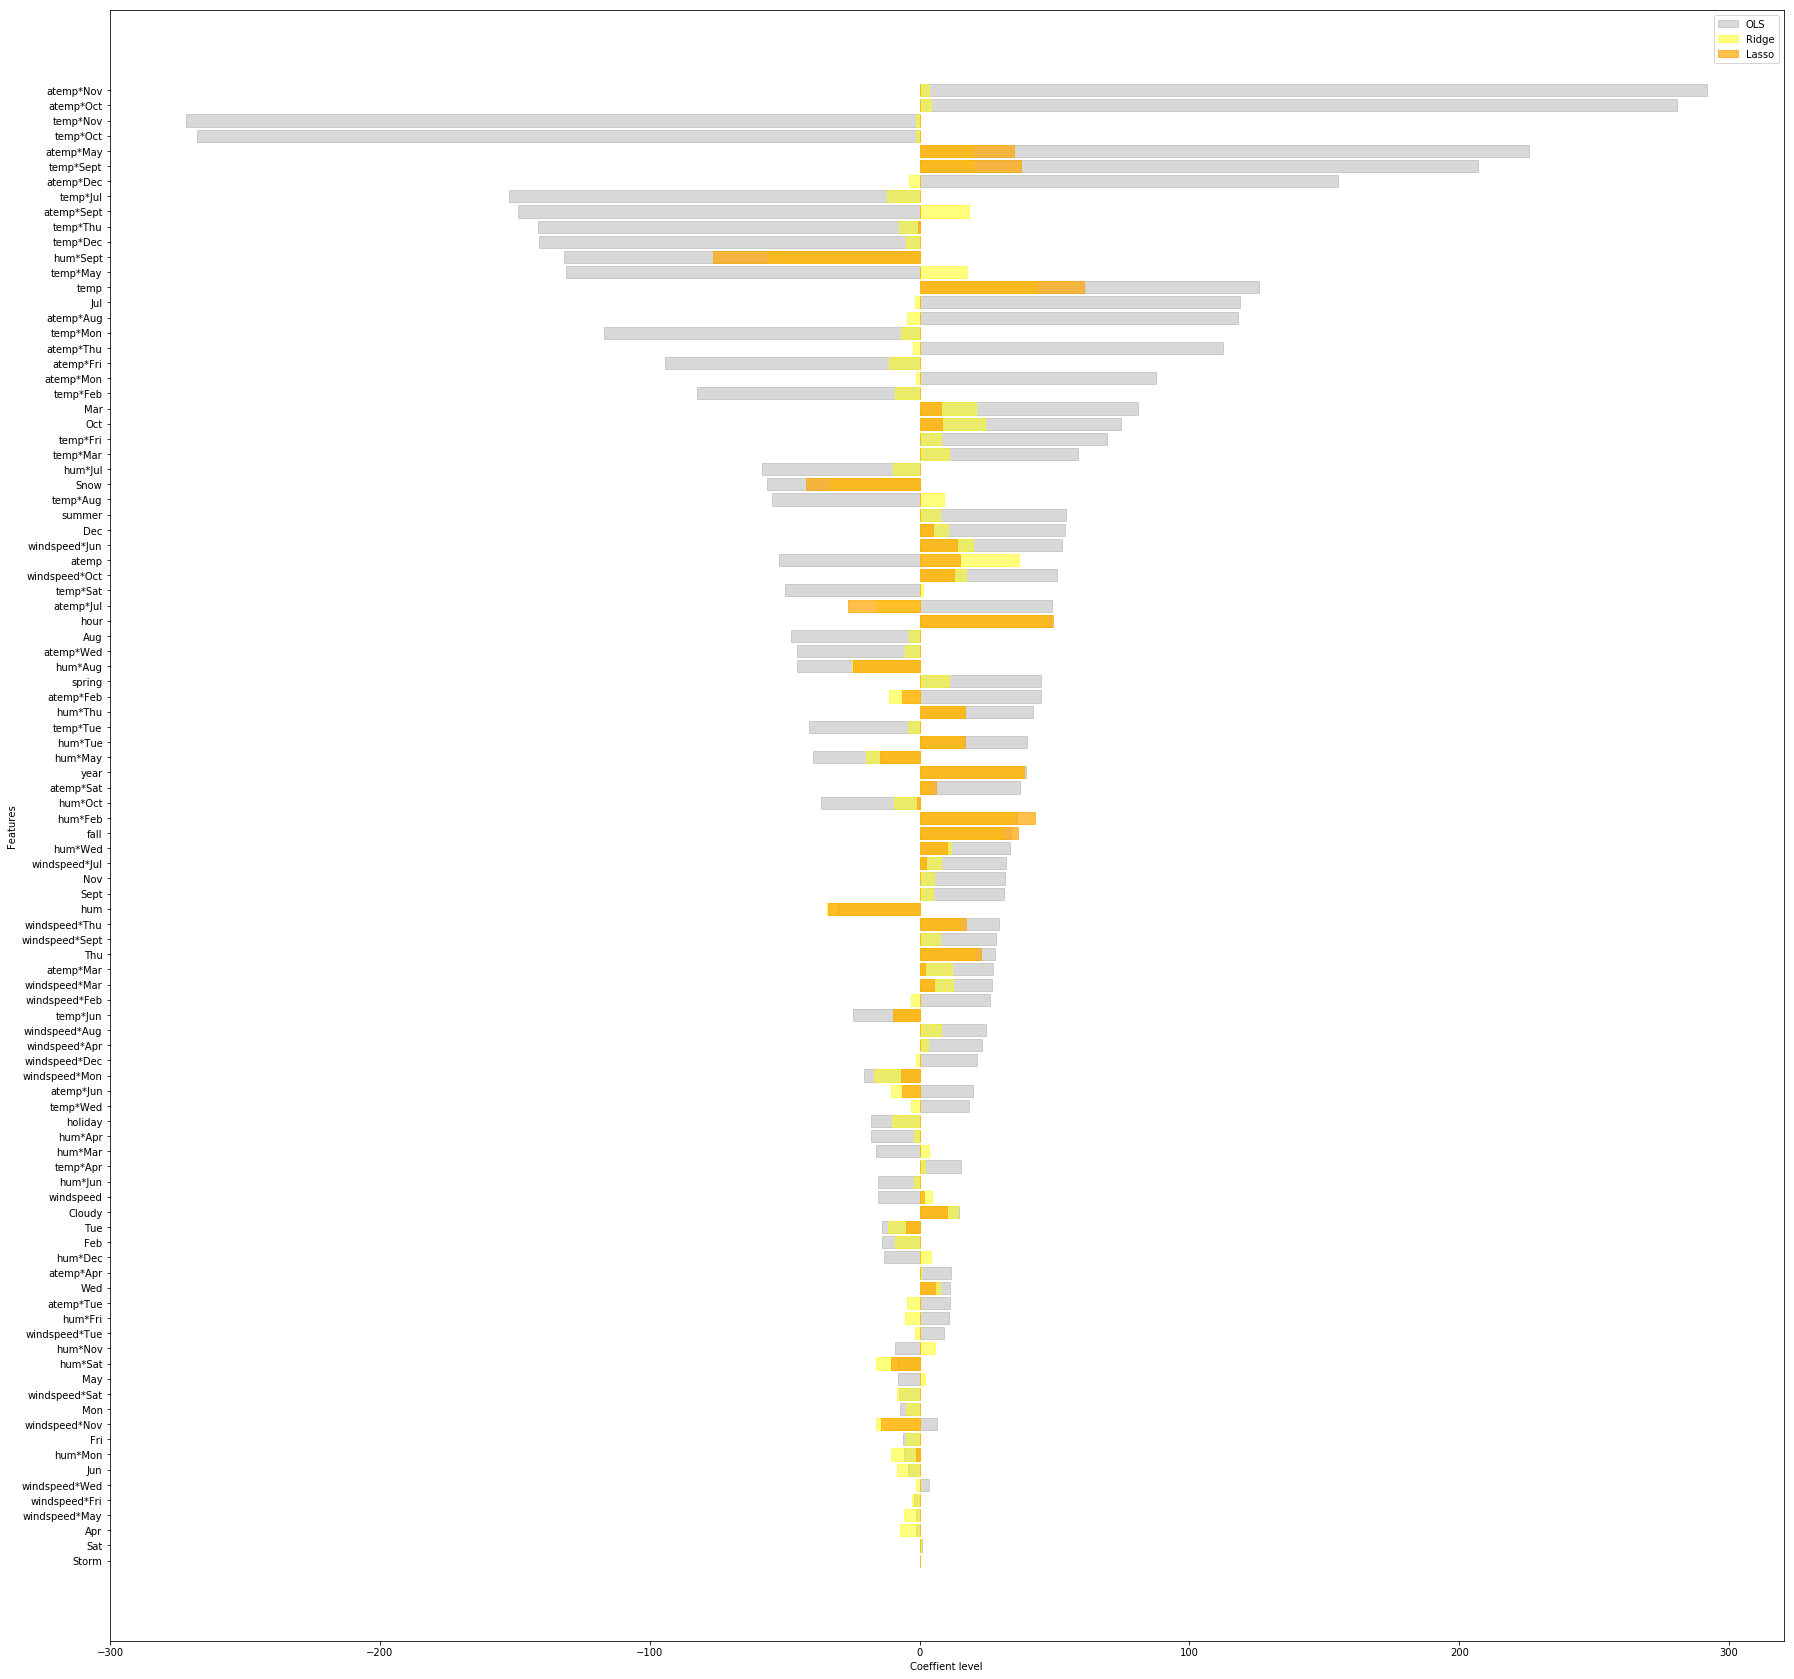

In [132]:
feature_names = x_train31.columns.values

Ridge_coefficients = fitted_ridge.coef_
Lasso_coefficients = fitted_lasso.coef_
OLS_coefficients = fitted_OLS.coef_

si= np.argsort(np.abs(fitted_OLS.coef_))
feature_names = x_train31.columns.values[si][0]
n_coeffs = len(feature_names)


fig=plt.figure(figsize=(30,30))
plt.barh(np.arange(n_coeffs),OLS_coefficients[0][si][0],label='OLS',Color='grey',alpha=0.3)
plt.barh(np.arange(n_coeffs),Ridge_coefficients[0][si][0],label='Ridge',Color='yellow',alpha=0.5)
plt.barh(np.arange(n_coeffs),Lasso_coefficients[si][0],label='Lasso',Color='orange',alpha=0.7)
plt.legend()
plt.yticks(np.arange(n_coeffs),feature_names)
plt.xlabel('Coeffient level')
plt.ylabel('Features')
plt.show()

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

In [160]:
x_train31.columns.values=='atemp'

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [161]:
idx=np.argwhere(((x_train31.columns.values=='atemp')|(x_train31.columns.values=='temp'))).flatten()
pd.DataFrame({'ridge_coef':fitted_ridge.coef_[0][idx],
              'lasso_coef': fitted_lasso.coef_[idx], 
              'ols_coef': fitted_OLS.coef_[0][idx]},index=['temp','atemp'])

,ridge_coef,lasso_coef,ols_coef
temp,43.210922,60.940567,125.936499
atemp,36.758312,14.820259,-52.196573


<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*your answer here*

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

*your answer here*

** 4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*your answer here*


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

*your answer here*
